# FIT5202 - Data processing for Big Data
# Assignment 2A: Building models to predict pedestrian traffic

### Name: Nan Xiao   Student No: 30280443

<div style="background:rgba(100,109,154,0.2);padding:10px;border-radius:4px">
<p><strong style="color:red">REFERENCE: </strong>The codes written in this script according to the references as follows</p>
<p> - https://spark.apache.org/docs/latest/configuration.html</p>
<p> - https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/tree/DecisionTreeModel.html</p>
</div>

# 1 Data Loading and exploration

## 1.1 Data loading

## 1.1.1 Get a SparkSession

In [1]:
# Import SparkConf class into program
# Code reference -- tutorial session 1
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"
# Config app name which will be shown on the Spark cluster UI page
app_name = "Melbourne pedestrian traffic"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession, Row # Spark SQL

# Configure timezone
# CODE REFERENCE -- https://stackoverflow.com/questions/49644232/apache-spark-how-to-set-timezone-to-utc-currently-defaulted-to-zulu
spark = SparkSession.builder.config(conf=spark_conf).config('spark.sql.session.timeZone', 'UTC').getOrCreate()

sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.1.2 Define the data schema

In [2]:
## https://docs.databricks.com/data/data-sources/read-csv.html
from pyspark.sql.types import *
import pyspark.sql.functions as F

# Define the schema
schema_p = StructType([
   StructField("ID", IntegerType(), True),
   StructField("Date_Time", TimestampType(), True),
   StructField("Year", IntegerType(), True),
   StructField("Month", StringType(), True),
   StructField("Mdate", IntegerType(), True),
   StructField("Day", StringType(), True),
   StructField("Time", IntegerType(), True),
   StructField("Sensor_ID", IntegerType(), True),
   StructField("Sensor_Name", StringType(), True),
   StructField("Hourly_Counts", IntegerType(), True)])

schema_s = StructType([
   StructField("sensor_id", IntegerType(), True),
   StructField("sensor_description", StringType(), True),
   StructField("sensor_name", StringType(), True),
   StructField("installation_date",  DateType(), True),
   StructField("status", StringType(), True),
   StructField("note", StringType(), True),
   StructField("direction_1", StringType(), True),
   StructField("direction_2", StringType(), True),
   StructField("latitude", FloatType(), True),
   StructField("longitude", FloatType(), True),
   StructField("location", StringType(), True)])


## 1.1.3 Load data

In [3]:
# Read data
df_count = spark.read.csv("Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv",\
                                 header=True, sep=",", schema=schema_p, timestampFormat = "MM/dd/yyyy hh:mm:ss a")

df_sensor = spark.read.csv("Pedestrian_Counting_System_-_Sensor_Locations.csv",\
                           header=True, sep=",", schema=schema_s, dateFormat = "yyyy/MM/dd")

In [4]:
# Print schema
df_count.printSchema()
df_sensor.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



## 1.1.4 Create an additional column

In [5]:
# Use user defined function to define the label rule.
label = F.udf(lambda x: 1 if x >= 2000 else 0, IntegerType())
# Add the above threshold column by using user defined function
df_count = df_count.withColumn('above_threshold', label(F.col('Hourly_Counts')))

In [6]:
df_count.show(4)

+-------+-------------------+----+--------+-----+------+----+---------+--------------------+-------------+---------------+
|     ID|          Date_Time|Year|   Month|Mdate|   Day|Time|Sensor_ID|         Sensor_Name|Hourly_Counts|above_threshold|
+-------+-------------------+----+--------+-----+------+----+---------+--------------------+-------------+---------------+
|2887628|2019-11-01 17:00:00|2019|November|    1|Friday|  17|       34|Flinders St-Spark La|          300|              0|
|2887629|2019-11-01 17:00:00|2019|November|    1|Friday|  17|       39|        Alfred Place|          604|              0|
|2887630|2019-11-01 17:00:00|2019|November|    1|Friday|  17|       37|     Lygon St (East)|          216|              0|
|2887631|2019-11-01 17:00:00|2019|November|    1|Friday|  17|       40|Lonsdale St-Sprin...|          627|              0|
+-------+-------------------+----+--------+-----+------+----+---------+--------------------+-------------+---------------+
only showing top

In [7]:
df_sensor.show(4)

+---------+--------------------+-----------+-----------------+------+----+-----------+-----------+----------+---------+--------------------+
|sensor_id|  sensor_description|sensor_name|installation_date|status|note|direction_1|direction_2|  latitude|longitude|            location|
+---------+--------------------+-----------+-----------------+------+----+-----------+-----------+----------+---------+--------------------+
|       59|    Building 80 RMIT|     RMIT_T|       2019-02-13|     A|null|      North|      South|-37.808258|144.96304|(-37.80825648, 14...|
|       20|Chinatown-Lt Bour...|   LtB170_T|       2013-09-06|     A|null|       East|       West| -37.81173|144.96825|(-37.81172913, 14...|
|       34|Flinders St-Spark La|    Fli32_T|       2014-06-08|     A|null|       East|       West| -37.81538|144.97415|(-37.81537985, 14...|
|       57|    Bourke St Bridge|   BouBri_T|       2018-08-13|     A|null|       West|       East|-37.817673|144.95026|(-37.8176735, 144...|
+---------+--

## 1.2 Exploring the data

<div style="background:rgba(0,109,80,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">DESCRIPTION: </strong>
<br>In this part, I will first use the summary funciton of dataframe to display the count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile information for each numerical columns. Then I will count and visualise the result of above threshold column to see if there is any class imblance. In the third question, the histogram graph will show the distribution of the hourly counts with log-scale and line chart will show the trend of the average daily count change by month. These two plots are plotted using matplotlib.pyplot library. In the fourth question, I plotted two charts. One is to show the pedestrians varies from Monday to Sunday. The other one is to show that the sensor direction also can be used to predict pedestrians.
</div>

## 1.2.1 Show the basic statistics 

In [8]:
# Get numerical column names
numericCols = [i for i in df_count.columns if isinstance(df_count.schema[i].dataType ,IntegerType)]
# Excluding above_threshold according to the requirements
numericCols.remove('above_threshold')
numericCols = [f'{x}' for x in df_count.columns if x in numericCols ]

In [9]:
# Show the basic statistics (including count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile)
df_count[numericCols].summary().toPandas()

,summary,ID,Year,Mdate,Time,Sensor_ID,Hourly_Counts
0,count,3435106,3435106,3435106,3435106,3435106,3435106
1,mean,1717553.5,2016.0032330880038,15.751918863639142,11.459955238644746,22.978422791028866,560.7805942524044
2,stddev,991629.8312350252,3.1237869143646275,8.79918757461428,6.943473866829414,16.229792156265397,809.9942576353371
3,min,1,2009,1,0,1,0
4,25%,858830,2014,8,5,9,50
5,50%,1717623,2016,16,11,19,210
6,75%,2576510,2019,23,17,34,722
7,max,3435106,2020,31,23,71,15979


## 1.2.2 Show the count of above-threshold and below-threshold

In [10]:
# import library
import matplotlib.pyplot as plt

In [11]:
# show the count of above threshold and below threshold in process activity

# first get the distinct value in above_threshold column
df_count.select('above_threshold').distinct().show()

+---------------+
|above_threshold|
+---------------+
|              1|
|              0|
+---------------+



In [12]:
above = df_count.select('above_threshold').filter(F.col('above_threshold') == 1).count()
below = df_count.select('above_threshold').filter(F.col('above_threshold') == 0).count()

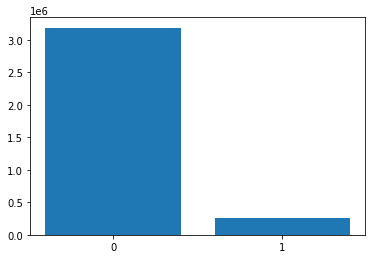

above: 250942
below: 3184164


In [13]:
# plot the data that we obtained in a bargraph using matplotlib
x = ["0", "1"]
plt.bar(x, [below, above])
plt.xticks()
plt.show()
print("above: " + str(above) + "\nbelow: " + str(below))

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
Yes, it has class imbalance. The above threshold has only 250942 counts, the below threshold has 3184164 counts.
As we can see from the two examples above, the imbalance between the numbers of attack and non-attack events are clear with the attacks accounting for ~7.3% of the the whole daily counting.
<br>Imbalance can have a great impact on the value and meaning of accuracy and other performance metrics. Prediction is biased towards classification with a large number of samples
<br> Reference:Luque, A., Carrasco, A., Martín, A., & de las Heras, A. (2019). The impact of class imbalance in classification performance metrics based on the binary confusion matrix. Pattern Recognition, 91, 216-231.
</div>

## 1.2.3 Display a histogram and a line chart

### The distribution of the hourly counts with log-scale for the frequency axis

In [14]:
# Get the log_scale of pedestrian hourly counts
log_scale = df_count.select(F.log(F.col('Hourly_Counts')).alias('log_scale'))

array([[<AxesSubplot:title={'center':'log_scale'}>]], dtype=object)

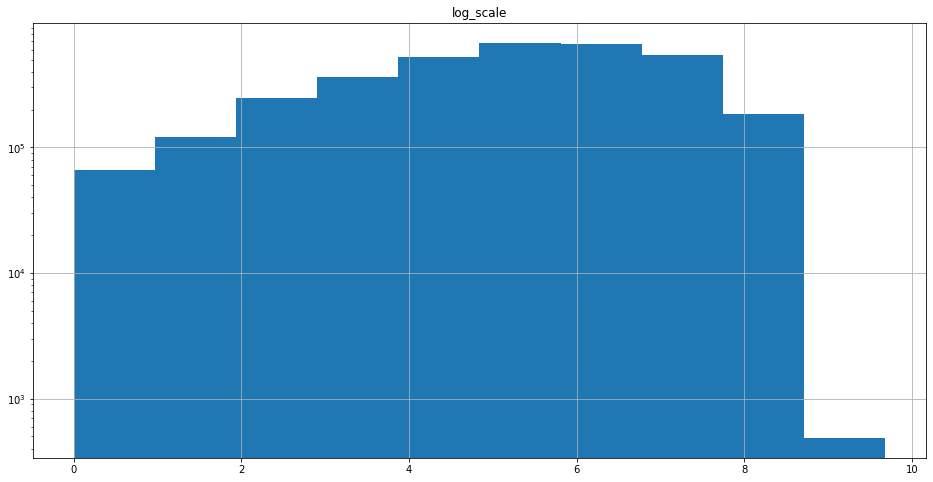

In [15]:
# Plot the histogram
df_hist_pd = log_scale.toPandas()
df_hist_pd.hist(column='log_scale', log=True, figsize=(16,8))

### Trend of average daily counts change by month 

In [16]:
# Calculate the average daily pedestrians of each month.
df_month_trend = df_count.select('Hourly_Counts', 'Date_Time', 'Mdate','Year')\
                         .withColumn('Month', F.month(F.col("Date_Time")))\
                         .groupBy('Year','Month','Mdate')\
                         .sum('Hourly_Counts')\
                         .groupBy('Month')\
                         .agg(F.mean('sum(Hourly_Counts)').alias('average_hourly_count'))\
                         .orderBy('Month')\
                         .collect()

In [17]:
df_month_trend

[Row(Month=1, average_hourly_count=461687.1348973607),
 Row(Month=2, average_hourly_count=504320.2186495177),
 Row(Month=3, average_hourly_count=505678.0381231672),
 Row(Month=4, average_hourly_count=459286.5515151515),
 Row(Month=5, average_hourly_count=419724.07258064515),
 Row(Month=6, average_hourly_count=415427.7916666667),
 Row(Month=7, average_hourly_count=432011.1451612903),
 Row(Month=8, average_hourly_count=421839.16397849465),
 Row(Month=9, average_hourly_count=436371.2138888889),
 Row(Month=10, average_hourly_count=449399.3306451613),
 Row(Month=11, average_hourly_count=472898.5388888889),
 Row(Month=12, average_hourly_count=499189.95014662755)]

Text(0, 0.5, 'avg_daily_count')

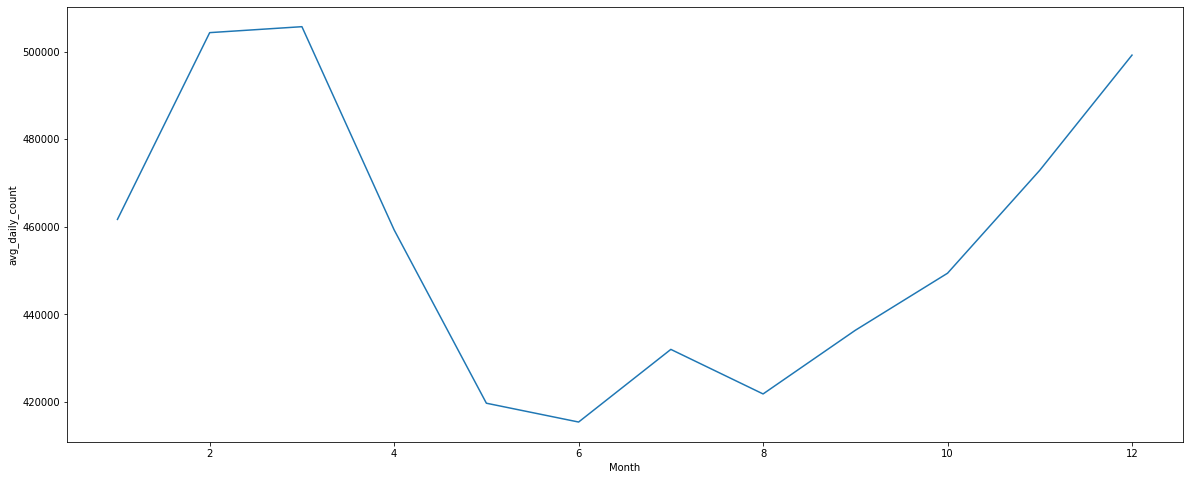

In [18]:
# Plot the trend line graph

avg_count = [data['average_hourly_count'] for data in df_month_trend]
month = [data['Month'] for data in df_month_trend]
# Modify the figure size
# https://stackoverflow.com/questions/17109608/change-figure-size-and-figure-format-in-matplotlib
plt.figure(figsize=(20,8))
# Plot the graph
plt.plot(month,avg_count)
plt.xlabel('Month')
plt.ylabel('avg_daily_count')

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">OBSERVATION: </strong>
<br>From the two charts above, there are some trends and conclusions that we can get.
<br>From the histogram, we can see the hourly counts data are mostly distributed averagly.
<br>From the line chart, we can see the daily pedestrian counts varies significantly in different month, so the month can be a good feature used in the prediction model training.
</div>

## 1.2.4. Two plots worthy of presenting to the MelbourneGig company

<div style="background:rgba(0,109,80,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TWO PLOTS: </strong>
<br>The first plot is to show the pedestrian counting difference from Monday to Sunday.
<br> The second plot is to find whether the direction can indicate some difference in the pedestrians counting.
</div>

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Bar chart: </strong>
<br>In the bar chart, x-axis represents Monday to Sunday, and y-axis represents the daily pedestrian counts in each day. From the result, we can see the pedestrian counts varies in different day of one week. On Monday, the number of pedestrains on street is the least, and on Saturday the number is most. This result is matched with our common sense, because most people need to work on Monday and will have rest on Saturaday. Therefore, the day of week can be a reasonable feature in the pedestrian prediction.
</div>

In [19]:
df_avg_hour_count = df_count.withColumn('DayofWeek', F.dayofweek('Date_Time'))\
                         .select('Hourly_Counts','Year','Month','DayofWeek','Mdate')\
                         .groupBy('Year','Month','DayofWeek','Mdate')\
                         .sum('Hourly_Counts')\
                         .groupBy('DayofWeek')\
                         .agg(F.mean('sum(Hourly_Counts)')\
                              .alias('average_hourly_count'))\
                         .orderBy('DayofWeek')\
                         .toPandas()
#df_avg_hour_count

Text(0, 0.5, 'avg_daily_count')

<Figure size 1440x576 with 0 Axes>

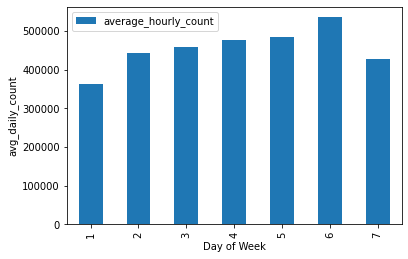

In [20]:
# Plot the bar graph

#avg_count = [data['average_hourly_count'] for data in df_avg_hour_count]
#day = [data['DayofWeek'] for data in df_avg_hour_count]
# Modify the figure size
# https://stackoverflow.com/questions/17109608/change-figure-size-and-figure-format-in-matplotlib
plt.figure(figsize=(20,8))
df_avg_hour_count.plot.bar(x='DayofWeek',y='average_hourly_count')
# Plot the graph
plt.xlabel('Day of Week')
plt.ylabel('avg_daily_count')

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Line chart</strong>
<br>This chart will show how the sensor direction related to the hourly pedestrian. There are two lines in the cahrt. One represents the direction of west-east and one represents the sensor direction of north-south. The y-axis represents the average hourly pedestrians counting in each hour in one day. The x-axis represents the time. From the result, we can easily see the north-south direciton sensor recorded more pedestrians in many time. Therefore, the direction is a good factor to predict the pedestrians.  
</div>

In [21]:
# Select the data that the direction is west and east from sensor locaiton dataframe
df_west_east = df_sensor.select('sensor_id','direction_1','direction_2')\
    .filter(((F.col("direction_1") == 'West') & (F.col("direction_2")=='East')) |\
            ((F.col("direction_1") == 'East') & (F.col("direction_2")=='West')))\
    .withColumn("direction", F.lit('WE'))
# Select the data that the direction is north and south from sensor locaiton dataframe
df_north_south = df_sensor.select('sensor_id','direction_1','direction_2')\
    .filter(((F.col("direction_1") == 'North') & (F.col("direction_2")=='South')) |\
            ((F.col("direction_1") == 'South') & (F.col("direction_2")=='North')))\
    .withColumn("direction", F.lit('NS'))
# Select the time and hourly counts data
df_count_sensor = df_count.select('Sensor_ID','Time','Hourly_Counts')
# Join the data
df_west_east_sensor = df_west_east.join(df_count_sensor,df_west_east.sensor_id == df_count_sensor.Sensor_ID )\
                                  .groupBy('Time')\
                                  .agg(F.avg(F.col('Hourly_Counts'))\
                                       .alias('Avg_we'))\
                                  .orderBy('Time')\
                                  .collect()
df_north_south_sensor = df_north_south.join(df_count_sensor,df_north_south.sensor_id == df_count_sensor.Sensor_ID  )\
                                  .groupBy('Time')\
                                  .agg(F.avg(F.col('Hourly_Counts'))\
                                       .alias('Avg_ns'))\
                                  .orderBy('Time').collect()

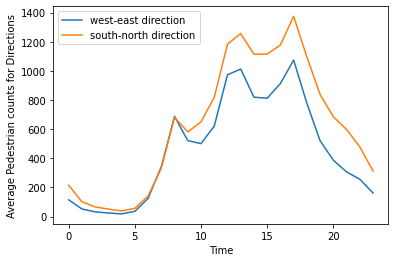

In [22]:
# Line chart

avg_count_we = [data['Avg_we'] for data in df_west_east_sensor]
avg_count_ns = [data['Avg_ns'] for data in df_north_south_sensor]
time = [data['Time'] for data in df_west_east_sensor]
# Prepare the line label
line1, = plt.plot(time,avg_count_we,label = "west-east direction")
line2, = plt.plot(time,avg_count_ns, label = "south-north direction")
# Plot the line chart
plt.xlabel('Time')
plt.ylabel('Average Pedestrian counts for Directions')
plt.legend(handles=[line1, line2])

# 2. Feature extraction and ML training ​

## 2.1 Discuss the feature selection and prepare the feature columns (12%)

## 2.1.1 Feature selecting

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<br>The columns I choose as features include Year, Month_Num (month of the year, Integer format), 
Day, Time, sensor_id, latitude, longitude, direction_1, direction_2.
<br><strong>Reasons for choosing the feature columns:</strong>
<br>    - Column Year, Month_Num, Day and Time are used as used as features since we would be performing a time series prediction, which predict the next hour’s count. According to Xianjing et al. (2017) ’s analysis, timestamp for each record in the dataset should be included in the dataset when we do time-series prediction, thus all the time-related data is used as features.
<br>    - Column sensor_id can uniquely identify the sensors, which can affect the prediction result especially when we make predictions on the existing sensors, thus sensor_id is used as features.
<br>    - Column latitude, longitude, direction_1, direction_2 decide the locations and directions of the sensors, which can also affect the hourly count of pedestrians the sensors can read, thus they are used as features as well.
<br>    - Other columns such sensor_description, sensor_name are not selected as features since they are just information of sensors and cannot affect the hourly count of pedestrians of sensors 
<br><strong>Create / Transform columns:</strong>
<br><strong>The dataset will be created in the following steps:</strong>
<br>    - Monthly pedestrian count dataframe: create the “Month_Num” column by reading the month from the “Date_Time” column (Timestamp column). Select the columns chosen as features. Filter the data frame, choose the record with time between 9 and 24.
<br>    - Sensor location dataframe: select the columns chosen as features.
<br>    - Join the two dataframe on sensor_id.
    
<br>Reference: Wang, X., Liono, J., McIntosh, W., & Salim, F. D. (2017, November). Predicting the city foot traffic with pedestrian sensor data. In Proceedings of the 14th EAI International Conference on Mobile and Ubiquitous Systems: Computing, Networking and Services (pp. 1-10).
</div>

## 2.1.2 Data preparation according to selection

In [23]:
# Select features in pedestrians count data
df_count_selected = df_count.withColumn('Month_Num', F.month(F.col("Date_Time")))\
    .select('Year','Month_Num','Mdate','Day','Time','Sensor_ID','Hourly_Counts','above_threshold')\
    .filter(df_count['Time'] >= 9).filter(df_count['Time'] <= 23).withColumnRenamed('Sensor_ID','sid')

# Select features in sensor data
#direction_udf = F.udf(lambda x: 1 if (x == 'West' or x == 'East') else 0, IntegerType())
df_sensor_selected = df_sensor.select('sensor_id','latitude','longitude', 'direction_1', 'direction_2')
                              
# Join these two dataframe
df_join = df_count_selected.join(df_sensor_selected, df_count_selected.sid == df_sensor_selected.sensor_id).drop('sid')

df_join.show(4)

+----+---------+-----+------+----+-------------+---------------+---------+----------+---------+-----------+-----------+
|Year|Month_Num|Mdate|   Day|Time|Hourly_Counts|above_threshold|sensor_id|  latitude|longitude|direction_1|direction_2|
+----+---------+-----+------+----+-------------+---------------+---------+----------+---------+-----------+-----------+
|2019|       11|    1|Friday|  17|          300|              0|       34| -37.81538|144.97415|       East|       West|
|2019|       11|    1|Friday|  17|          604|              0|       39|-37.813797|144.96996|      South|      North|
|2019|       11|    1|Friday|  17|          216|              0|       37|-37.803104|144.96672|      North|      South|
|2019|       11|    1|Friday|  17|          627|              0|       40|-37.809994|144.97227|      South|      North|
+----+---------+-----+------+----+-------------+---------------+---------+----------+---------+-----------+-----------+
only showing top 4 rows



## 2.2 Preparing Spark ML Transformers/Estimators for features, labels and models

<div style="background:rgba(0,109,80,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">DESCRIPTION: </strong>
<br>In this part, I will prepare Spark ML transformers and estimators for features, labels and models. The transformers are StringIndexer, OneHotEncoder and VectorAssembler and the estimators are DecisionTreeClassifier,GBTClassifier, GBTRegressor and DecisionTreeRegressor.
<br>First I need to select the string columns and numerical columns. Then use the stringIndexer to transform the string value to indices. Then encode the indices as binary vectors by using OneHotEncoder and combine all the features including the numerical columns into a single feature column by using VectorAssembler.
<br>Next I will use the ML estimators and specify the hyperparameters (maxIter and maxBins).
</div>

### 2.2.1Write code to create Transformers/Estimators for transforming/assembling the columns

In [24]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier
from pyspark.ml.regression import GBTRegressor,DecisionTreeRegressor
from pyspark.ml import Pipeline

In [25]:
# Select the string and numerical column name from joined data
stringCols = [i for i in df_join.columns if isinstance(df_join.schema[i].dataType ,StringType)]
numCols = [ i for i in df_join.columns if i not in stringCols and i != 'Hourly_Counts' and i != 'above_threshold']

In [26]:
print(stringCols)
print(numCols)

['Day', 'direction_1', 'direction_2']
['Year', 'Month_Num', 'Mdate', 'Time', 'sensor_id', 'latitude', 'longitude']


In [27]:
# Use case 1 transformer
# Prepare the feature for classification

output1_C = [f"{i}_index" for i in stringCols]
# Encode string columns as indices
stage1_C = StringIndexer(inputCols = stringCols, outputCols = output1_C)
output2_C =  [f"{i}_vec" for i in output1_C]
# Encode the indices as binary vectors
stage2_C = OneHotEncoder().setInputCols([i for i in output1_C]).setOutputCols(output2_C)
# Combine all the features into a single feature column
stage3_C = VectorAssembler().setInputCols(output2_C + numCols).setOutputCol("features_C")
# ML estimitor
# Decision Tree classification 
stage4_C_DT = DecisionTreeClassifier(featuresCol = 'features_C', labelCol = 'above_threshold', maxDepth = 5, maxBins = 20)
# Gradian Boost classification
stage4_C_GBT = GBTClassifier(featuresCol = 'features_C', labelCol = 'above_threshold', maxIter = 20)

In [28]:
# Use case 2 transformer
# Prepare the feature for classification

output1_R = [f"{i}_index" for i in stringCols]
# Encode string columns as indices
stage1_R = StringIndexer(inputCols = stringCols, outputCols = output1_R)
output2_R =  [f"{i}_vec" for i in output1_R ]
# Encode the indices as binary vectors
stage2_R = OneHotEncoder().setInputCols([i for i in output1_R ]).setOutputCols(output2_R)
# Combine all the features into a single feature column
stage3_R = VectorAssembler().setInputCols(output2_R + numCols).setOutputCol("features_R")
# ML estimitor
# Decision Tree regression
stage4_R_DT = DecisionTreeRegressor(featuresCol = 'features_R', labelCol = 'Hourly_Counts', maxDepth = 6, maxBins = 20)
# Gradian Boost regression
stage4_R_GBT= GBTRegressor(featuresCol = 'features_R', labelCol = 'Hourly_Counts', maxIter = 20)

### 2.2.2 Write code to include the above Transformers/Estimators into pipelines

In [29]:
from pyspark.ml import Pipeline

In [30]:
# # Configure two ML classification pipeline, which consists of 4 stages
# Decision Tree classification 
pipeline_C_DT = Pipeline(stages = [stage1_C, stage2_C, stage3_C, stage4_C_DT])
# Gradian Boost classification
pipeline_C_GBT = Pipeline(stages = [stage1_C, stage2_C, stage3_C, stage4_C_GBT])

In [31]:
# Configure two ML regression pipeline, which consists of 4 stages
# Decision Tree regression
pipeline_R_DT = Pipeline(stages = [stage1_R, stage2_R, stage3_R, stage4_R_DT])
# Gradian Boost regression
pipeline_R_GBT = Pipeline(stages = [stage1_R, stage2_R, stage3_R, stage4_R_GBT])

### 2.2.3 For the Decision Tree classification model you have created, explain the purposes of the hyperparameters of maxDepth and maxBin, and how they impact the model in theory and in this use case

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<strong>maxDepth</strong> means the Maximum depth of the tree (e.g. depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). The deeper the tree, the better the calculation effect (may get higher accuracy), but it may also be more expensive to train and more likely to cause overfit.
<strong>maxBins</strong> means maximum number of bins used for splitting features
Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication.

<br>Reference: https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/tree/DecisionTreeModel.html
</div>

## 2.3 Preparing the training data and testing data

<div style="background:rgba(0,109,80,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">DESCRIPTION: </strong>
<br>In this part, I will prepare the training data and testing data. 
<br>Firstly, only the features selected in last part will be used. For this data, the data between 2014 and 2018 (including 2018) is for training purpose and the data in 2019 is for testing purpose.Also, we need to fill the null value with 'NA'
<br> In addition, the dataframe for classification cannot include hourly counts and the dataframe for regression cannot include above_threshold.
</div>

In [32]:
# Prepare the training data for classification prediction
df_train_classify = df_join.filter((df_join['Year'] >= 2014) \
                                   & (df_join['Year'] <= 2018))\
                           .select('Year','Mdate','direction_1'\
                                   ,'direction_2','Month_Num','Day'\
                                   ,'Time','above_threshold','sensor_id'\
                                   ,'latitude','longitude')\
                           .na.fill('NA')
# Prepare the testing data for classification prediction                           
df_test_classify = df_join.filter((df_join['Year'] == 2019))\
                        .select('Year','Mdate','direction_1'\
                                ,'direction_2','Month_Num','Day'\
                                ,'Time','above_threshold','sensor_id'\
                                ,'latitude','longitude')\
                        .na.fill('NA')
# Prepare the training data for regression prediction
df_train_regressor = df_join.filter((df_join['Year'] >= 2014) \
                                    & (df_join['Year'] <= 2018))\
                            .select('Year','Mdate','direction_1','direction_2'\
                                    ,'Month_Num','Day','Time','Hourly_Counts'\
                                    ,'sensor_id','latitude','longitude')\
                            .na.fill('NA')
# Prepare the testing data for regression prediction                           
df_test_regressor = df_join.filter((df_join['Year'] == 2019))\
                           .select('Year','Mdate','direction_1'\
                                   ,'direction_2','Month_Num'\
                                   ,'Day','Time','Hourly_Counts'\
                                   ,'sensor_id','latitude','longitude')\
                           .na.fill('NA')
# cache the training and testing data                           
df_train_classify = df_train_classify.cache()
df_test_classify = df_test_classify.cache()
df_train_regressor = df_train_regressor.cache()
df_test_regressor = df_test_regressor.cache()

In [33]:
df_train_classify.count()

1102919

In [34]:
df_test_classify.count()

285532

In [35]:
df_train_regressor.count()

1102919

In [36]:
df_test_regressor.count()

285532

## 2.4 Training and evaluating models 

<div style="background:rgba(0,109,80,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">DESCRIPTION: </strong>
<br>In this part, I will train and evaluate the classification and regression models.
<br>First is to use the pipeline model to fit the training dataset and transform the testing data to get the predictions. 
<br> Then I will use BinaryClassificationEvaluator to evaluate the classificaiton models and RegressionEvaluator to evaluate the regression models.
</div>

## Use case 1

### 1.Train model and perform predictions

In [67]:
# Use the train data to train the Decision Tree classification model
classification_model_DT = pipeline_C_DT.fit(df_train_classify)
# Perform predictions by using test data
classification_predictions_DT = classification_model_DT.transform(df_test_classify)
#classification_predictions_DT.show(10,truncate=False)

In [38]:
# Use the train data to train the Gradian Boost classification model
classification_model_GBT = pipeline_C_GBT.fit(df_train_classify)
# Perform predictions by using test data
classification_predictions_GBT = classification_model_GBT.transform(df_test_classify)
#classification_predictions_GBT.toPandas().head(20)

### 2.Display metrics and discuss

In [68]:
# Display the count of each combination of above-threshold/below-threshold label 
# and prediction label of Decision Tree model
classification_predictions_DT.groupBy('above_threshold','prediction').count().show()

+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0| 11724|
|              0|       0.0|246830|
|              1|       1.0| 19317|
|              0|       1.0|  7661|
+---------------+----------+------+



In [40]:
# Display the count of each combination of above-threshold/below-threshold label 
# and prediction label of Gradian Boost model
classification_predictions_GBT.groupBy('above_threshold','prediction').count().show()

+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0| 12810|
|              0|       0.0|249638|
|              1|       1.0| 18231|
|              0|       1.0|  4853|
+---------------+----------+------+



In [41]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def compute_metrics(predictions):
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="above_threshold")
    # calculate AUC
    auc = evaluator.evaluate(predictions)
    #to calculate accuracy,precision,recall
    TN = predictions.filter('prediction = 0 AND above_threshold = 0').count()#find the True Negative
    TP = predictions.filter('prediction = 1 AND above_threshold = 1').count()#find the True Positive
    FN = predictions.filter('prediction = 0 AND above_threshold = 1').count()#find the False Negative
    FP = predictions.filter('prediction = 1 AND above_threshold = 0').count()#find the False Positive
    accuracy =  (TN + TP) / predictions.count()  #formula to find accuracy
    precision =   (TP) / (TP + FP)  #formula to find precision
    recall =  (TP) / (TP + FN) #formula to find recall
    print("AUC", auc)
    print("accuracy", accuracy )
    print("precision",precision)
    print("recall",recall)

In [42]:
print("Compute the AUC, accuracy, recall and precision for Decision Tree model")
compute_metrics(classification_predictions_DT)

Compute the AUC, accuracy, recall and precision for Decision Tree model
AUC 0.6030761573761163
accuracy 0.9321091856604514
precision 0.7160278745644599
recall 0.6223059824103605


In [43]:
print("Compute the AUC, accuracy, recall and precision for Gradient Boosted Tree model model")
compute_metrics(classification_predictions_GBT)

Compute the AUC, accuracy, recall and precision for Gradient Boosted Tree model model
AUC 0.9551591678211453
accuracy 0.9381400333412717
precision 0.7897678045399411
recall 0.5873199961341452


- Discuss which metric is more proper for measuring the model performance on predicting above-threshold events, in order to give the performers good recommendations while reducing the chance of falsely recommending a location.

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<br>Precision and AUC is more proper for measuring the model performance.
<br>What I want to recommend the performers are the records that have prediction above threshold 2000. After looking through the dataset we can find that above threshold == 1 (threshold above 2000) is the minority class. In this condition, accuracy is not a very good metrics since accuracy= TP+TN / TP+TN+FP+FN, make an extreme example, even when all the prediction results are 0, the accuracy of that model will still high since the number of records that have above threshold == 0 is much more than the number of records that have above threshold == 1. 
<br>After comparing recall and precision, I can decide that precision is more proper when measuring model performance, since precision=TP / TP+FP, which is the percentage of records correctly predicted as above threshold == 1 among all the records predicted as above threshold == 1. Through measure the model performance using precision, we can give the performers good recommendations while reducing the chance of falsely.
<br>AUC is also a proper metric for  measuring the model performance, since it’s the area under the ROC curve and it measure the model performance in general regardless of origin probability of classes.

</div>

- Discuss which is the better model, and persist the better model.


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
Based on the above analysis of metrics, Precision and AUC are more proper for  measuring the model performance. After comparing the metrics of decision tree model and GBT model, I can see that GBT model has higher value for both precision and AUC, thus GBT model is the better model.
</div>

In [44]:
# Saves the model to the filesystem
classification_model_GBT.write().overwrite().save('pedestrian_prediction_model_classification')

In [45]:
# Test if the model has been saved.
# Loading the Pipeline Model From the filesystem
from pyspark.ml import PipelineModel
classification_model = PipelineModel.load('pedestrian_prediction_model_classification')
print(classification_model.stages[-1]._java_obj.paramMap())

{
	GBTClassifier_e67acad22948-featuresCol: features_C,
	GBTClassifier_e67acad22948-labelCol: above_threshold,
	GBTClassifier_e67acad22948-maxIter: 20
}


### Leaf node splitting criteria and top-3 features

In [46]:
# Get the decision tree stage
tree = classification_model_DT.stages[-1]

In [47]:
display(tree)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_021143acf144, depth=5, numNodes=41, numClasses=2, numFeatures=21

In [49]:
# Print out the leaf node splitting criteria
print(tree.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_021143acf144, depth=5, numNodes=41, numClasses=2, numFeatures=21
  If (feature 18 <= 6.5)
   If (feature 17 <= 18.5)
    If (feature 17 <= 11.5)
     If (feature 17 <= 10.5)
      Predict: 0.0
     Else (feature 17 > 10.5)
      If (feature 8 in {1.0})
       Predict: 0.0
      Else (feature 8 not in {1.0})
       Predict: 1.0
    Else (feature 17 > 11.5)
     If (feature 18 <= 4.5)
      Predict: 1.0
     Else (feature 18 > 4.5)
      If (feature 14 <= 2014.5)
       Predict: 0.0
      Else (feature 14 > 2014.5)
       Predict: 1.0
   Else (feature 17 > 18.5)
    If (feature 17 <= 19.5)
     If (feature 20 <= 144.96477508544922)
      If (feature 15 <= 1.5)
       Predict: 0.0
      Else (feature 15 > 1.5)
       Predict: 1.0
     Else (feature 20 > 144.96477508544922)
      If (feature 2 in {1.0})
       Predict: 1.0
      Else (feature 2 not in {1.0})
       Predict: 0.0
    Else (feature 17 > 19.5)
     If (feature 2 in {1

In [50]:
# Get the decision tree stage
classification_model_DT.stages[-1].featureImportances

SparseVector(21, {2: 0.0093, 8: 0.0093, 9: 0.0121, 14: 0.0127, 15: 0.0004, 17: 0.3383, 18: 0.4835, 19: 0.1286, 20: 0.0059})

In [51]:
df_test_classify.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- direction_1: string (nullable = false)
 |-- direction_2: string (nullable = false)
 |-- Month_Num: integer (nullable = true)
 |-- Day: string (nullable = false)
 |-- Time: integer (nullable = true)
 |-- above_threshold: integer (nullable = true)
 |-- sensor_id: integer (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



In [53]:
# Reference: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name
import pandas as pd
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    var_list = pd.DataFrame(list_extract)
    var_list['score'] = var_list['idx'].apply(lambda x: featureImp[x])
    return(var_list.sort_values('score', ascending = False))

In [54]:
classification_model_DT.stages[-1]

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_021143acf144, depth=5, numNodes=41, numClasses=2, numFeatures=21

In [63]:
# Display the top 3 important features for Decision Tree model
ExtractFeatureImp(classification_model_DT.stages[-1].featureImportances, classification_predictions_DT, "features_C").head(3)

,idx,name,score
4,18,sensor_id,0.483458
3,17,Time,0.338307
5,19,latitude,0.128585


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<br>The top 5 important features include sensor id, time of the day, location, year and direction.
<br>If it is before 18:30 of the day, there’s a high probability that the hourly count of sensors is below 2000, the cross will be not very busy.
<br>If it is between 18:30 and 19:30 of the day, the longitude is less than 144.96477508544922, and it is January, there’s a high probability that the hourly count of sensors is below 2000, else if it is other months of the year, there’s a high probability that the hourly count of sensors is above 2000 which means the cross will be very busy.
<br>If it is between 18:30 and 19:30 of the day, the longitude is greater than 144.96477508544922, here’s a high probability that the hourly count of sensors is above 2000.
<br>If it is after 19:30 of the day, the latitude is less than -37.813472747802734, there’s a high probability that the hourly count of sensors is below 2000, else if the latitude is greater than -37.813472747802734, there’s a high probability that the hourly count of sensors is above 2000.
</div>

### 4 Suggestions to improve the prediction

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<br><strong>Suggestion1: Cross validation.</strong>
<br>Tune the models with cross validation. With cross validation, we can find the combination of hyper parameters which gives us the best prediction / performance among all the combinations of the  chosen values for chosen parameters. The reasons of why cross validation can improve the models’ performance basic includes:
<br>
<br>* With cross validation, we can make use of all of our data. In use case 1, we built only one model for decision tree and one model for gradient boosted tree, and the training and testing dataset are not very big, which make the models’ performance not very good. But with cross validation, we build K different models, so we are able to make predictions on all of our data and choose the best performed model. In this way, we can improved the performance of the model.
<br>* With cross validation, we can fine-tune the hyper parameters. As mentioned above, we can find the best combination of parameters. This can be done by trying different values and choosing the best ones. The hyper parameters we always tune for decision tree model includes: maxDepth, maxBins, minInfoGain and so on. The hyper parameters we always tune for gradient boosted tree model includes: maxDepth, maxBins, minInfoGain, lossType. We can set some values for these parameters and then use cross validation to find the best combination parameters. In this way, we can find a model which have better prediction on use case 1. 
<br>Reference: https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79#:~:text=Cross%2DValidation%20is%20a%20very,different%20steps%20of%20the%20pipeline.
<br><strong>Sample implementation :</strong>
</div>

In [ ]:
# The code here for idea
# Create ParamGrid for Cross Validation
#dtparamGrid = (ParamGridBuilder()
             .addGrid(stage4_C_DT.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(stage4_C_DT.maxBins, [10, 20, 40, 80, 100])
             .build())
# Define an evaluator to be used for evaluating the model 
#dtevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
# Create 3-fold CrossValidator
#dtcv = CrossValidator(estimator = pipeline_C_DT,
                      labelCol = 'above_threshold',
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 3)
# Run cross validations
#dtcvModel = dtcv.fit(df_train_classify)
#Getting the best model and the optimum parameters selected from the Cross Validation 
#bestModel= dtcvModel.bestModel
#bestModel.stages[-1]._java_obj.paramMap()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<br><strong>Suggestion 2: Try other classification models.</strong>
<br>Another method to improve the prediction of use case 1 is trying other classification models, for example Random forest classification. 
<br>A decision tree is a simple, decision making-diagram. Random forests model includes a large number of trees, combined (using averages or "majority rules") at the end of the process. Gradient boosting tree model also combines decision trees, but start the combining process at the beginning, instead of at the end. 
<br>Reference: https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained
<br>Thus Random forest can reduce the variance seen in decision trees through using different
samples for training, specifying random feature subsets, and building and combining small 
(shallow) trees.
When it comes to the comparison between Random forest model and Gradient boosted tree model, Random forest can have better performance when the dataset have a lot of noise.
Thus Random forest model may improve the prediction of use case 1.
<strong>Implementation:</strong>
</div>

In [ ]:
# The code here for idea
# Implement Random Forest Classifier
# Create a Random Forest Classiication model and train it
#rf = RandomForestClassifier(featuresCol = 'features_C', labelCol = 'above_threshold', numTrees=5)
#rf_model = rf.fit(df_train_classify)
#rf_prediction = rf_model.transform(df_test_classify)

### Use case 2

### Train model and perform predictions

In [56]:
# We use the train data to train the Decision Tree regression model
regression_model_DT = pipeline_R_DT.fit(df_train_regressor)
# Perform predictions by using test data
regression_predictions_DT = regression_model_DT.transform(df_test_regressor)
#regression_predictions_DT.toPandas().head(20)

In [57]:
# We use the train data to train the Gradian Boost regression model
regression_model_GBT = pipeline_R_GBT.fit(df_train_regressor)
# Perform predictions by using test data
regression_predictions_GBT = regression_model_GBT.transform(df_test_regressor)
#regression_predictions_GBT.toPandas().head(20)

### Compute the RMSE, R-squared

In [58]:
from pyspark.ml.evaluation import RegressionEvaluator
# Rmse 
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="Hourly_Counts",
                                predictionCol="prediction")
rmse_DT = evaluator_rmse.evaluate(regression_predictions_DT)
rmse_GBT = evaluator_rmse.evaluate(regression_predictions_GBT)
print("Root-mean-square error = " + str(rmse_DT))
print("Root-mean-square error = " + str(rmse_GBT))

Root-mean-square error = 547.0553496989834
Root-mean-square error = 477.93144253532483


In [59]:
evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="Hourly_Counts",
                                predictionCol="prediction")
r2_DT = evaluator_r2.evaluate(regression_predictions_DT)
r2_GBT = evaluator_r2.evaluate(regression_predictions_GBT)
print("DT R2 = " + str(r2_DT))
print("GBT R2 = " + str(r2_GBT))

DT R2 = 0.6078488896044996
GBT R2 = 0.7006893868305428


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
The Gradian Boost regression model is better, since the RMSE value is smaller and the R-squared value is bigger.
</div>

In [60]:
# Saves the model to the filesystem
regression_model_GBT.write().overwrite().save('pedestrian_prediction_model')

In [61]:
# Test if the model has been saved.
# Loading the Pipeline Model From the filesystem
from pyspark.ml import PipelineModel
regressionModel = PipelineModel.load('pedestrian_prediction_model')
print(regressionModel.stages[-1]._java_obj.paramMap())

{
	GBTRegressor_769f5f1ab0a0-featuresCol: features_R,
	GBTRegressor_769f5f1ab0a0-labelCol: Hourly_Counts,
	GBTRegressor_769f5f1ab0a0-maxIter: 20
}


# 3. Knowledge sharing (6%)

In [62]:
from pyspark.ml.clustering import KMeans

customer_df = spark.createDataFrame([ (0,19,15,39),
(0,21,15,81),
(1,20,16,6),
(1,23,16,77),
(1,31,17,40),
(1,22,17,76),
(1,35,18,6),
(1,23,18,94),
(0,64,19,3),
(1,30,19,72),
(0,67,19,14),
(1,35,19,99),
(1,58,20,15)],                                    
['gender', 'age', 'annual_income', 'spending_score'])

assembler = VectorAssembler(
        inputCols=['gender', 'age', 'annual_income', 'spending_score'],
        outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(customer_df))

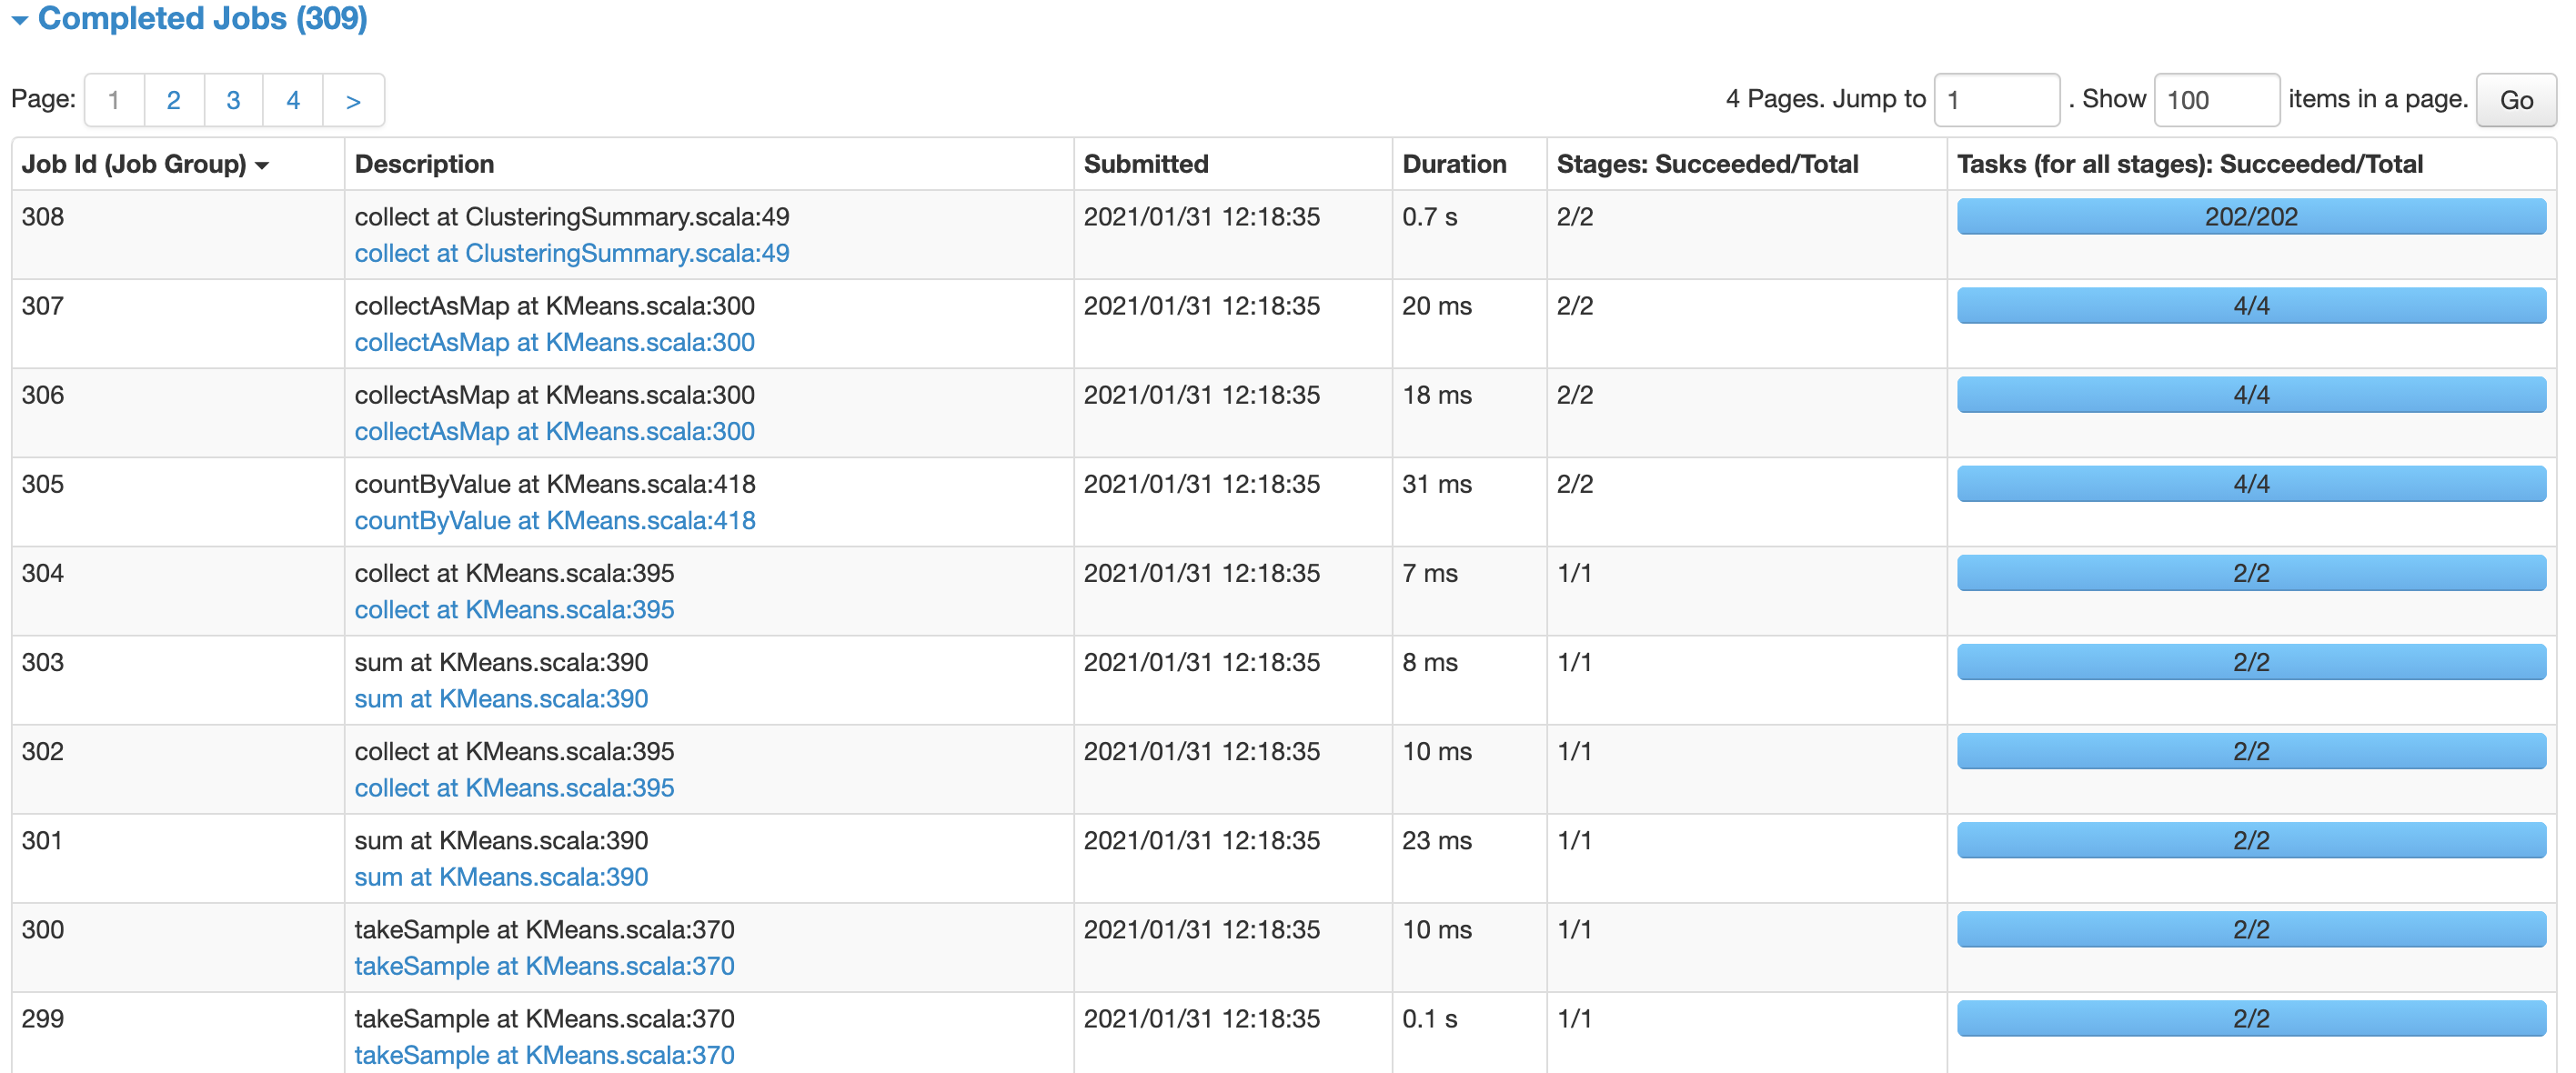

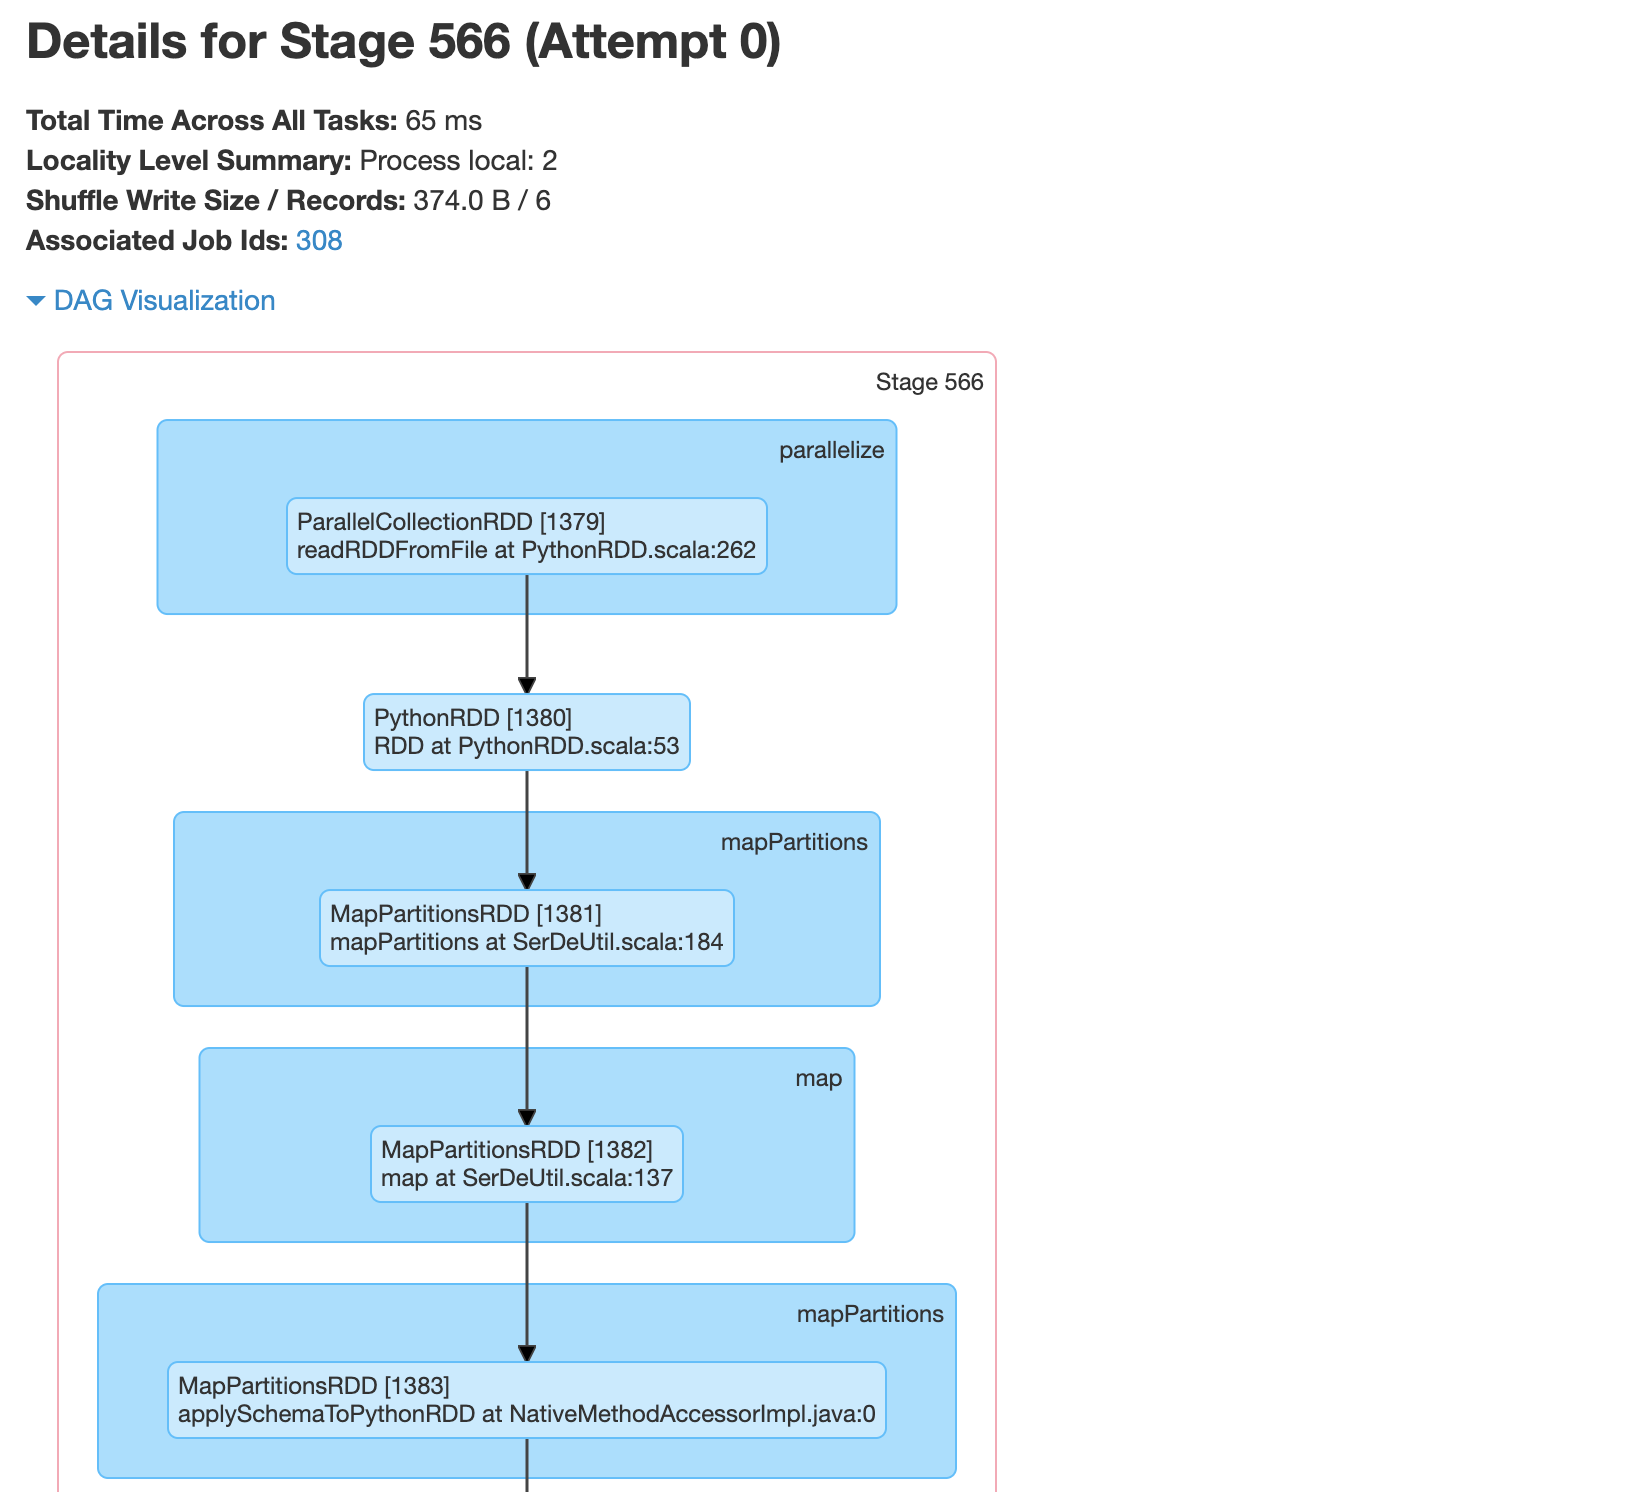
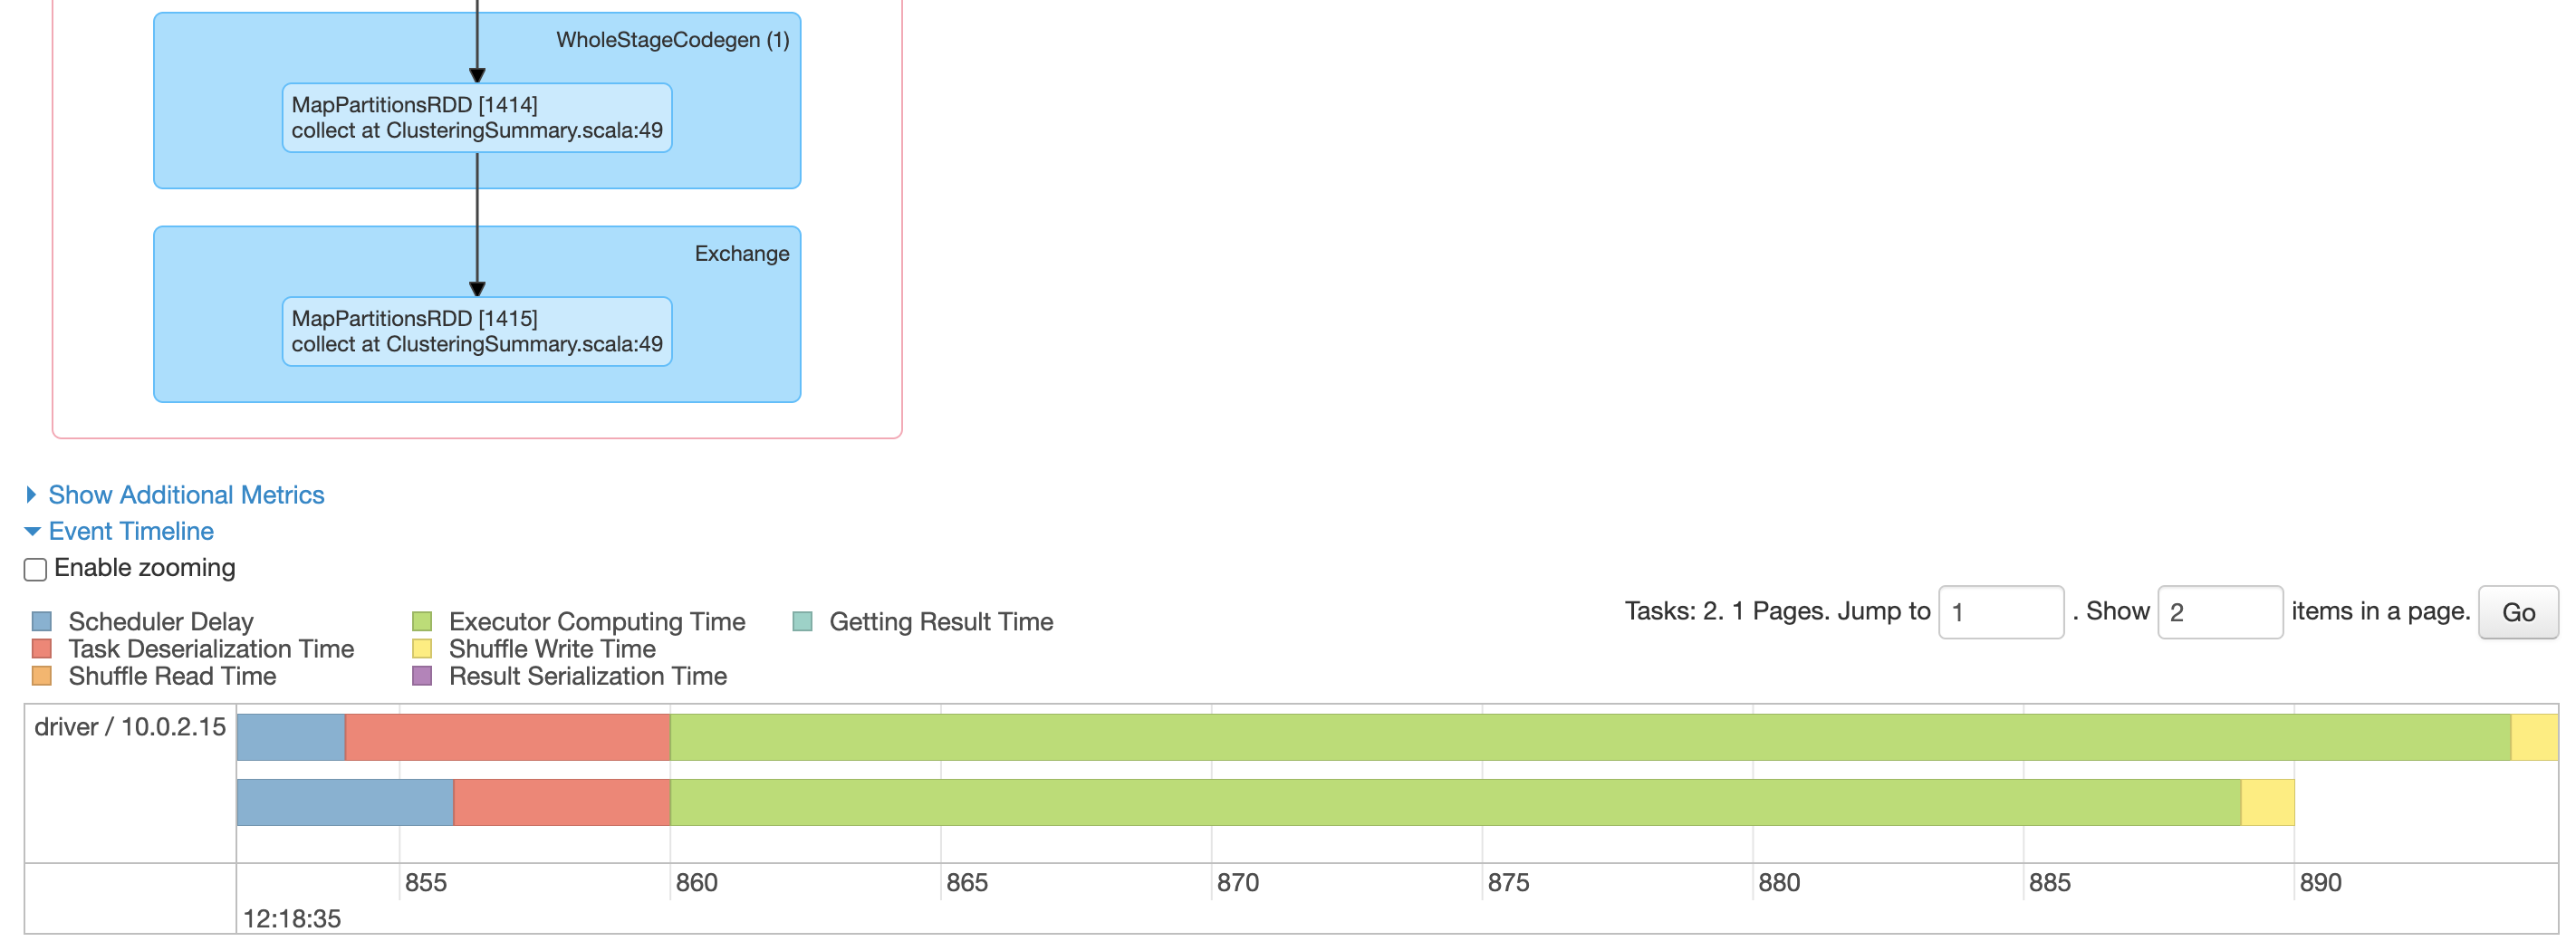

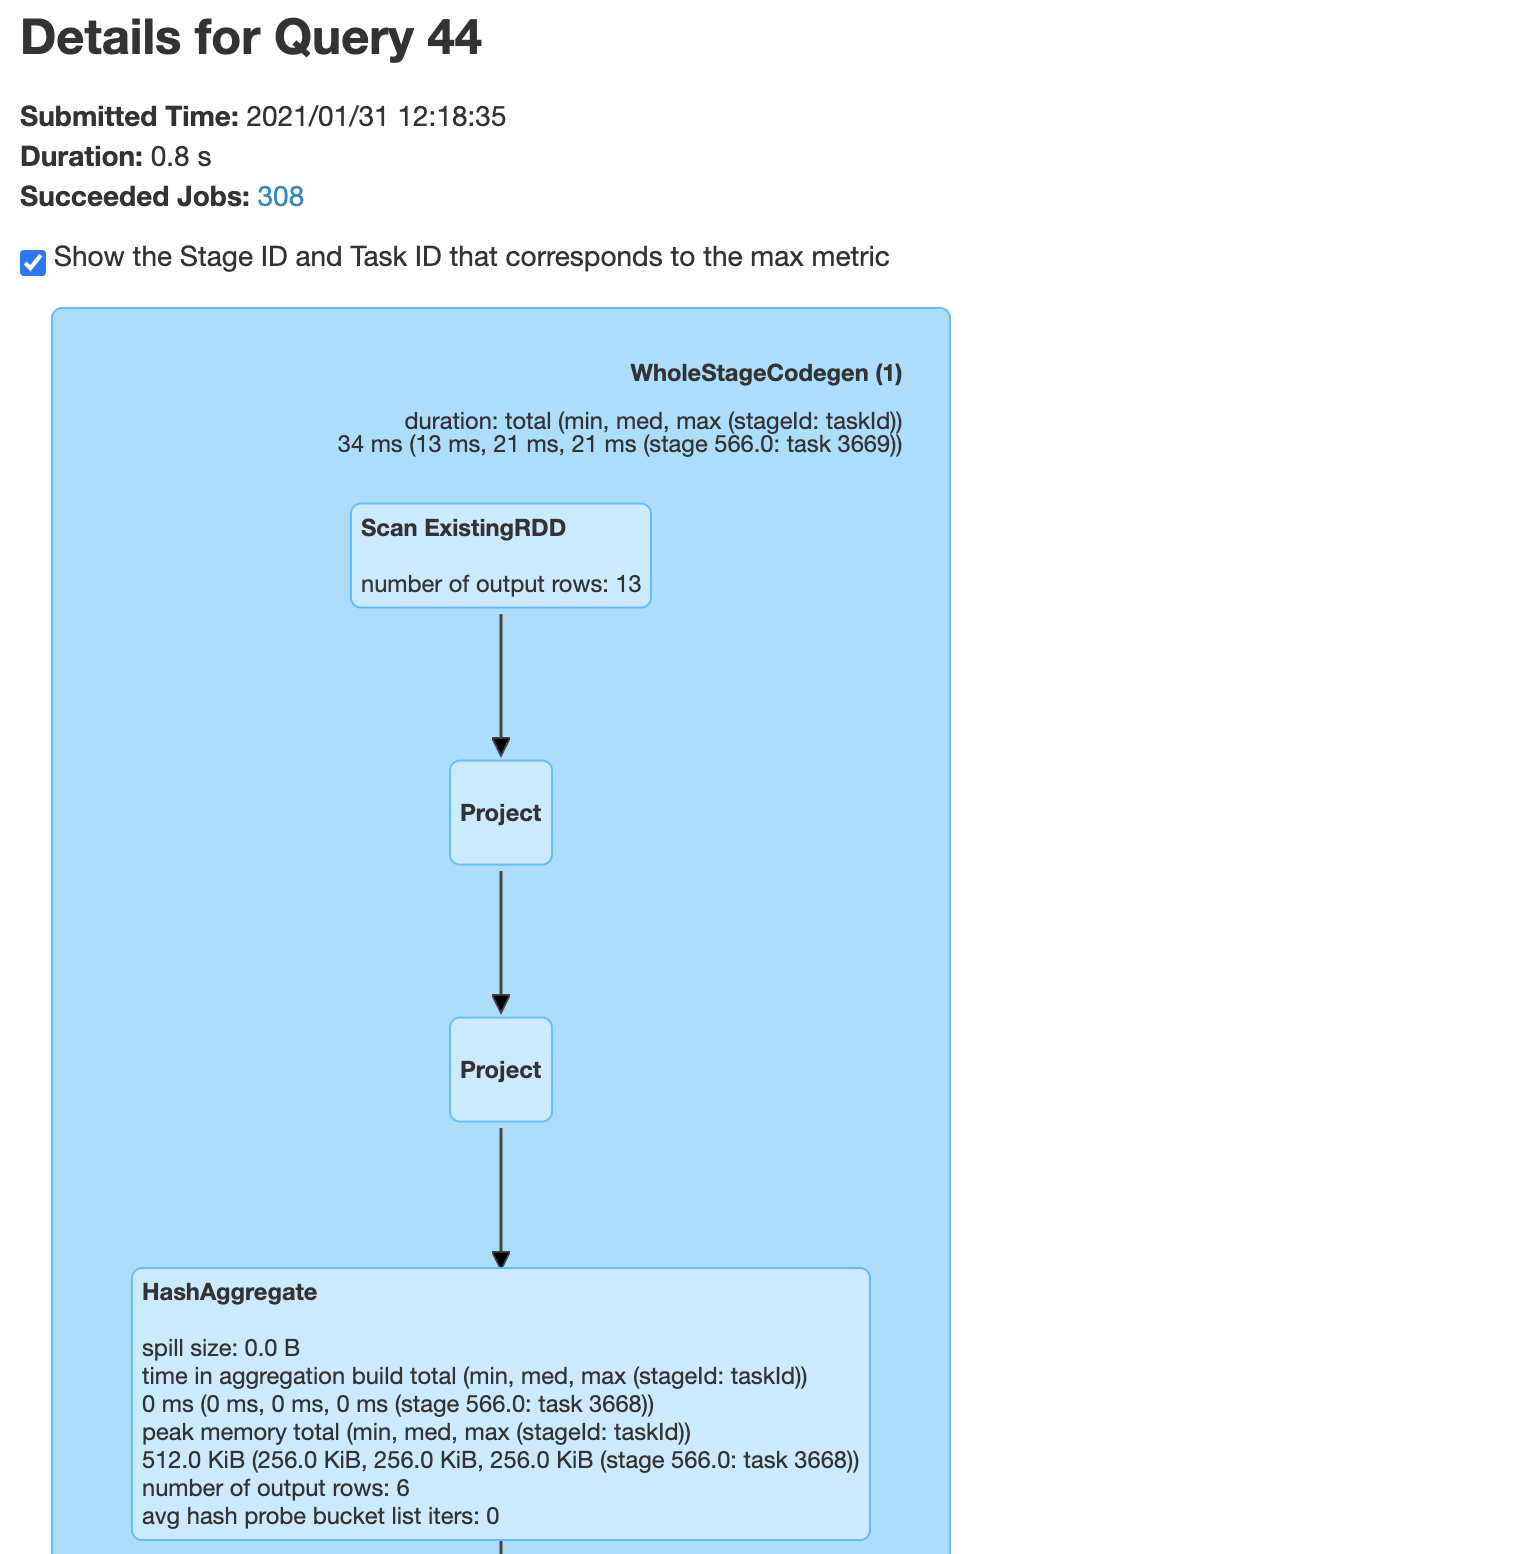
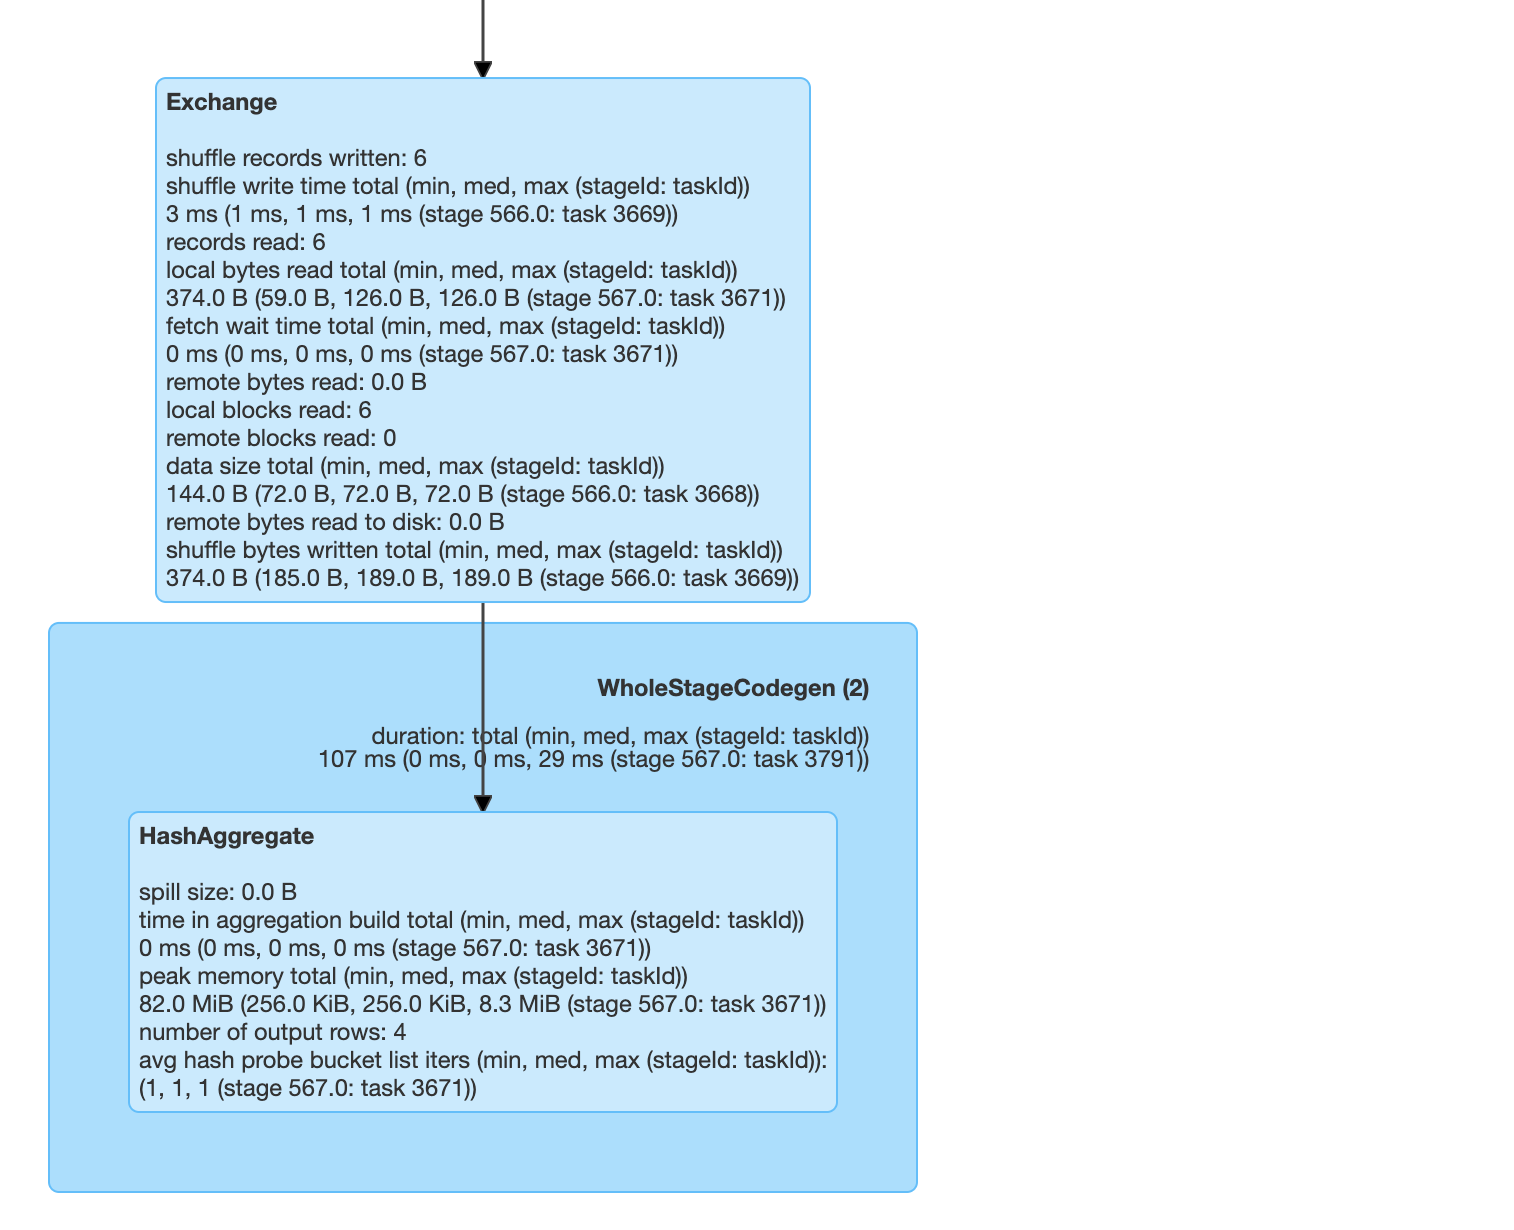

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">ANSWER: </strong>
<br>K-means is a partitional clustering algorithm and the k-means in spark is parallelism. The data parallelism means the data are distributed to different clusters in different processors and after the whole iterations of clustering, it will be collected. But in result parallelism, the data are moved from one processor to another processor after each iteration.
<br>We know that we have two processors, so the jobs are split into two partitions. From the spark UI we can see there are 10 jobs related to K-means. From the details for the query we can see that there is an exchange between two hash-aggregate, so the result parallelism is being adopted in the implementation of KMeans clustering in Sparl 
<br>Reference:https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala
</div>